# Stroke prediction

## Introduction

The goal of this project is to predict if a person is going to suffer a stroke or not.


### Background

A stroke occurs when the blood supply to part of your brain is interrupted or reduced, preventing brain tissue from getting oxygen and nutrients. Brain cells begin to die in minutes. A stroke is a medical emergency, and prompt treatment is crucial. Early action can reduce brain damage and other complications. The good news is that many fewer Americans die of stroke now than in the past. Effective treatments can also help prevent disability from stroke.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn
import imblearn

from bokeh.io import push_notebook, output_notebook, show
from bokeh.palettes import Category20c
from bokeh.plotting import figure
from bokeh.transform import cumsum

In [2]:
output_notebook()

sns.set_style('whitegrid')
cmap = sns.color_palette("Blues", as_cmap=True)

%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

Loading BokehJS ...

Scikit-learn objects are inherently random. The randomness of these objects is controlled via their random_stateparameter. 

We set the underlying numpy seed to a deterministic value to make the experiments reproducible.

In [3]:
from sklearn.utils import check_random_state

np.random.seed(42)
assert check_random_state is not None, "Set numpy seed for determinism."

In [4]:
df = pd.read_csv('../dataset/stroke.csv').drop(columns=['id'])

In [5]:
df.head()

gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  67.0             0              1          Yes        Private   
1  Female  61.0             0              0          Yes  Self-employed   
2    Male  80.0             0              1          Yes        Private   
3  Female  49.0             0              0          Yes        Private   
4  Female  79.0             1              0          Yes  Self-employed   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban             228.69  36.6  formerly smoked       1  
1          Rural             202.21   NaN     never smoked       1  
2          Rural             105.92  32.5     never smoked       1  
3          Urban             171.23  34.4           smokes       1  
4          Rural             174.12  24.0     never smoked       1

In [6]:
df.shape

(5110, 11)

In [7]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [8]:
categorical_cols = df.select_dtypes(include=object).columns
binary_cols = ['stroke', 'hypertension', 'heart_disease']
numerical_cols = df.select_dtypes(include=np.number).columns.drop(binary_cols)

print(f'Numerical variables: {len(numerical_cols)}')
print(f'Categorical variables: {len(categorical_cols) + len(binary_cols)}')

Numerical variables: 3
Categorical variables: 8


In [9]:
df[categorical_cols].describe()

gender ever_married work_type Residence_type smoking_status
count     5110         5110      5110           5110           5110
unique       3            2         5              2              4
top     Female          Yes   Private          Urban   never smoked
freq      2994         3353      2925           2596           1892

## EDA

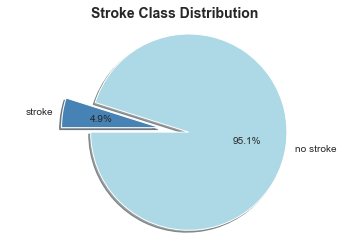

In [10]:
fig1, ax1 = plt.subplots()

ax1.pie(df['stroke'].value_counts(), 
        explode=[0, 0.3], 
        labels=['no stroke', 'stroke'], 
        autopct='%1.1f%%',
        shadow=True,
        colors=['lightblue', 'steelblue'],
        startangle=180)
ax1.set_title('Stroke Class Distribution', loc='center', 
              y=1.0, fontsize=14, fontweight='bold')
ax1.axis('equal')

plt.show()

The dataset is **imbalanced**. We will take this into account in the next sections by using a resampling method such as SMOTE.

In [11]:
from math import pi

len_data = len(df)
len_m = len(df[df["gender"]=="Male"])
len_w = len_data - len_m

men_stroke = len(df.loc[(df["stroke"]==1)&(df['gender']=="Male")])
men_no_stroke = len_m - men_stroke

women_stroke = len(df.loc[(df["stroke"]==1) & (df['gender']=="Female")])
women_no_stroke = len_w - women_stroke

x = {
    'Men with stroke': men_stroke,
    'Women with stroke': women_stroke,
    'Men healthy': men_no_stroke,
    'Women healthy': women_no_stroke
}
          
data = pd.Series(x).reset_index(name='value').rename(columns={'index':'label'})
data['angle'] = data['value']/data['value'].sum() * 2*pi
data['color'] = Category20c[len(x)]

p = figure(plot_height=350, toolbar_location=None,
           tools="hover", tooltips="@label: @value", x_range=(-0.5, 1.0))
p.title.text = 'Stroke class grouped by gender'
p.title.align = 'center'
p.title.text_color = 'black'
p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='label', source=data)

p.axis.axis_label=None
p.axis.visible=False
p.grid.grid_line_color = None

show(p)

The classes representation seems to be proportioned when partition by each numerical variable.

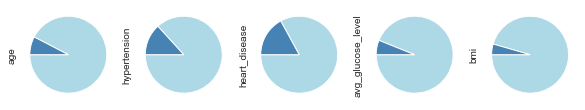

In [12]:
_ = df.groupby(['stroke']).sum().plot(kind='pie', 
                                      subplots=True, 
                                      figsize=(10,5),
                                      layout=(1,5),
                                      colors=['lightblue', 'steelblue'],
                                      legend=False,
                                      labels=None,
                                      startangle=180)

Next, we are going to have a look at the **categorical variables**.

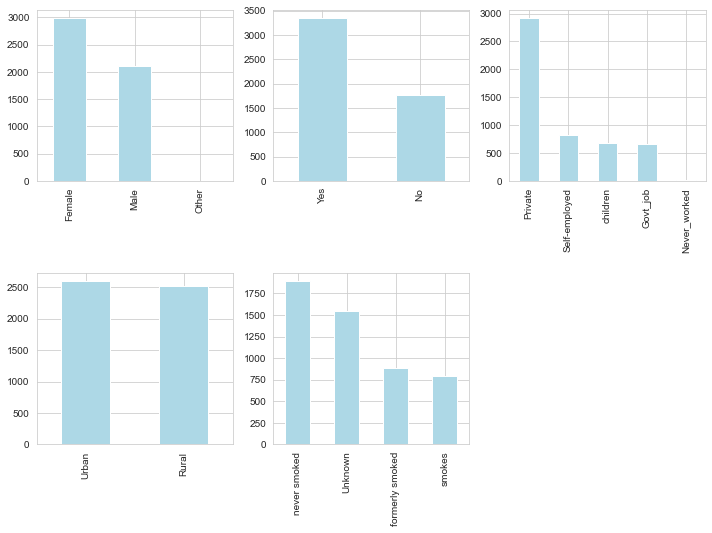

In [13]:
fig, axes = plt.subplots(3,3,figsize=(10,10))

for i, c in enumerate(categorical_cols):
  if c == 'stroke': pass
  ax = axes.reshape(-1)[i]
  df[c].value_counts().plot(kind='bar', ax=ax, color=['lightblue'])

# Do not show empty plots
for ax in axes.reshape(-1)[len(categorical_cols):]:
    ax.set_visible(False)
    
plt.tight_layout()

...and how stroke is distributed among the categorical variables.

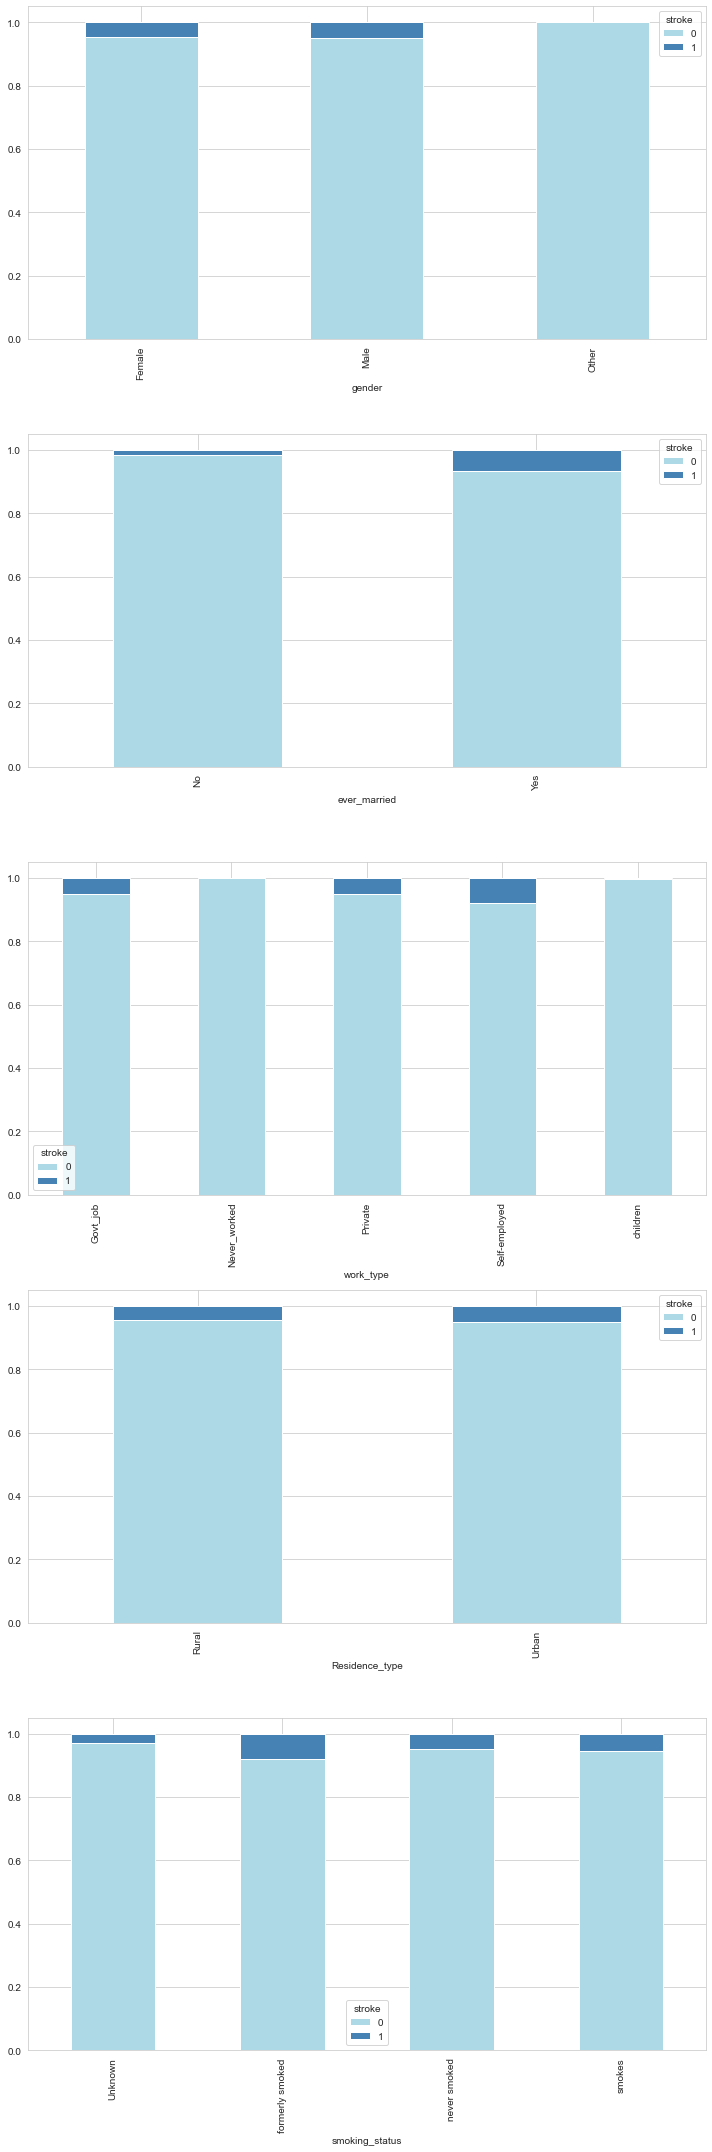

In [14]:
fig, axes = plt.subplots(5,1,figsize=(10,30))

for i, c in enumerate(categorical_cols):
    ax = axes.reshape(-1)[i]
    ct = pd.crosstab(index=df[c], columns=df['stroke'],normalize='index')
    a = ct.plot(kind='bar', stacked=True, ax=ax, color=['lightblue', 'steelblue'])

# Do not show empty plots
for ax in axes.reshape(-1)[len(categorical_cols):]:
    ax.set_visible(True)
    
plt.tight_layout()

- Stroke doesn't seem to be highly correlated to smoke since the proportion of person having a strok is farily the same among the different smoking status.
- Men are more prone to stroke than women.
- The gender does not discriminite a person having a stroke or not.
- Hypertension and heart disease does affect a person having a stroke.
- Rural people is less prone to stroke.

Let's have a look at the KDE plots of the **numerical variables** by stroke.

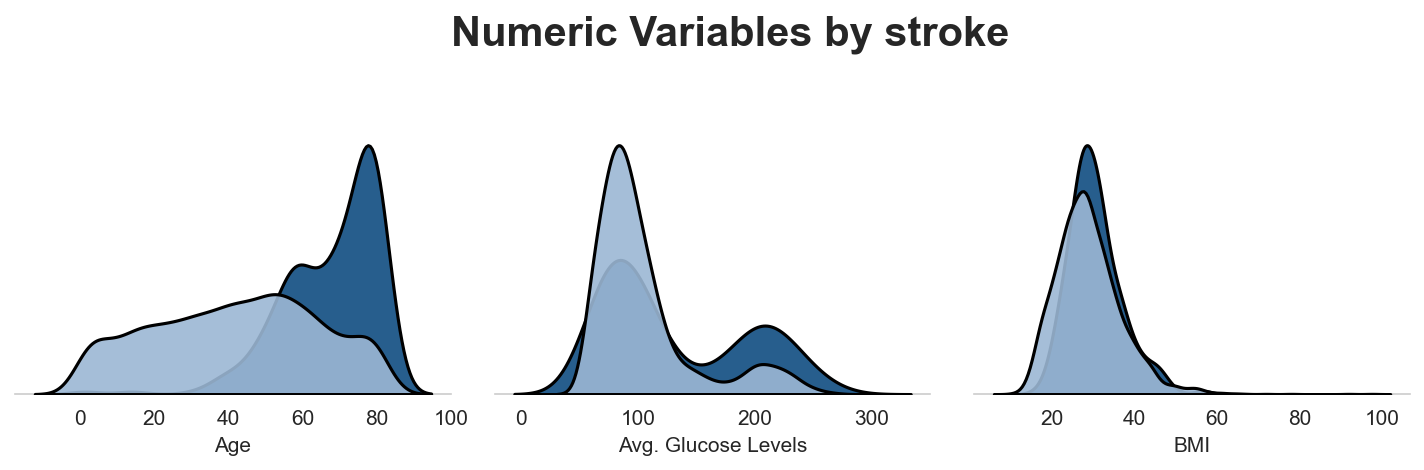

In [15]:
fig = plt.figure(figsize=(12, 12), dpi=150)
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)

plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0

s = df[df['stroke'] == 1]
ns = df[df['stroke'] == 0]

for feature in numerical_cols:
        sns.kdeplot(s[feature], ax=locals()["ax"+str(plot)], color='#0f4c81', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        sns.kdeplot(ns[feature],ax=locals()["ax"+str(plot)], color='#9bb7d4', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        plot += 1

ax0.set_xlabel('Age')
ax1.set_xlabel('Avg. Glucose Levels')
ax2.set_xlabel('BMI')
        
ax0.text(100, 0.056, 'Numeric Variables by stroke', fontsize=20, fontweight='bold')

plt.show()

Age looks to be a prominent factor.

## Preprocessing

Age should be rounded to a natural.

In [16]:
df['age'] = df['age'].apply(round)

Binary categorical variables should be modeled properly.

In [17]:
def binary2Categorical(df, cols):
  for c in cols:
    df[c] = pd.cut(df[c], bins=[-0.5,0.5,1.5], labels=['no', 'yes'])

In [18]:
binary_cols = ['hypertension', 'heart_disease']    
binary2Categorical(df, binary_cols)
categorical_cols = df.select_dtypes(include=[object, 'category']).columns

### Dealing with outliers

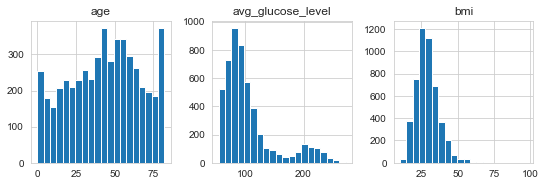

In [19]:
_ = df[numerical_cols].hist(bins=20, layout=(2,3), figsize=(9,6))

We are not applying log scale to _avg_glucose_level_ nor _bmi_ since the skewness is not concerning.

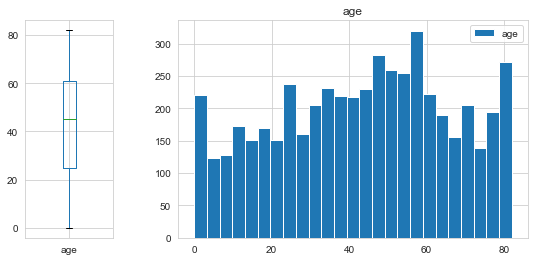

In [20]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,4))
df.boxplot(column='age',ax=axes[0])
_ = df.hist(bins=25, column='age', ax=axes[1], legend=True)

Here we could have used IQR filtering but it would have removed the values of the extrem of the interval which is no good.

After some research [Overweight & Obesity](https://www.cdc.gov/obesity/adult/defining.html), we have considered $15 \leq \text{BMI} \leq 60$ an outlier.

In [21]:
df['bmi'] = df['bmi'].apply(lambda bmi_value: bmi_value if 15 < bmi_value < 60 else np.nan)

There is only one person with 'Other' gender so we will consider it an outlier.

In [22]:
df = df[df['gender'] != 'Other']

### Replace Low Frequency Categorical Variables

In [23]:
def replaceLowFreq(df, threshold=0.1, replacement='other'):
    f = lambda x: x.map(x.value_counts(normalize=True)) >= threshold
    r = df[categorical_cols].where(df[categorical_cols].apply(f), replacement)
    df[categorical_cols] = r

#replaceLowFreq(df, threshold=0.1)

We decided **not** to group low frequency categorical variables because each categorical variables has already a small range of possible values.

### Imputation

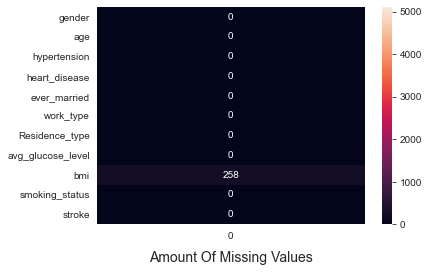

In [24]:
def displayMissingValues():
    plt.title('Amount Of Missing Values',fontsize=14, y=-0.2)
    ax = sns.heatmap(pd.DataFrame(df.isna().sum()),annot=True, fmt='d', vmin=0, vmax=df.shape[0])
displayMissingValues()

We are going to impute the missing bmi values using a Decision Tree based with variables age and gender since it is clear that there is a correlation between those three variables.

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

imp_dt = DecisionTreeRegressor()

pipe = \
  Pipeline(steps=[('scale',StandardScaler()), 
                  ('imputer', imp_dt)])

X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
pipe.fit(X,Y)
predicted_bmi = pd.Series(pipe.predict(Missing[['age','gender']]), index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi

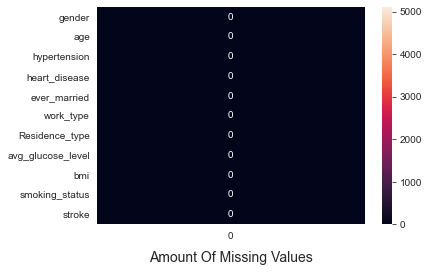

In [26]:
displayMissingValues()

#### Kernel Density Estimate

Visualizing the distribution of observations in the dataset.

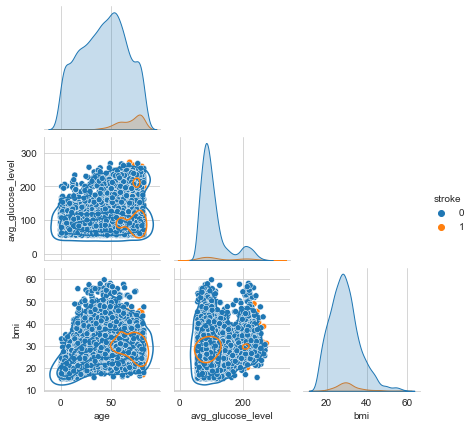

In [27]:
g = sns.pairplot(df, diag_kind="kde", hue='stroke', corner=True, height=2.0)
_ = g.map_lower(sns.kdeplot, levels=4, color=".2")

#### Correlation Map

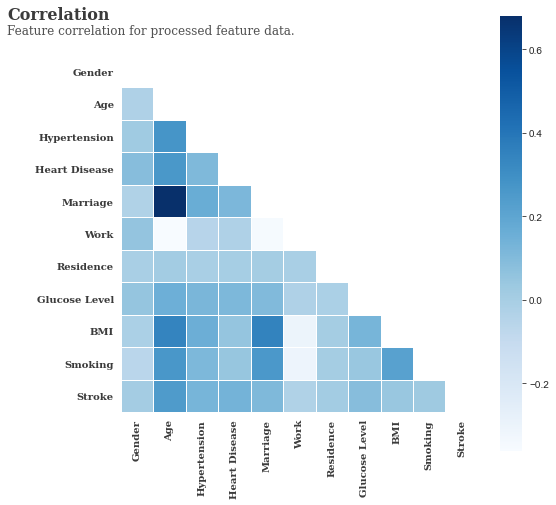

In [28]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df_aux = df.apply(encoder.fit_transform)
corr = df_aux.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(corr, ax=ax, fmt='.2f',
            cmap=cmap, annot=False,
            mask=mask,
            linewidths=.5, square=True)
ax.text(-3.5,-1.1, 'Correlation',{'font':'serif', 'size': 16, 'weight':'bold'}, alpha = 0.9)
ax.text(-3.5,-0.65, 'Feature correlation for processed feature data.',{'font':'serif', 'size': 12, 'weight':'normal'}, alpha = 0.8)
ax.tick_params(axis = 'y', rotation=0)
xticks = ['Gender', 'Age', 'Hypertension',
          'Heart Disease', 'Marriage', 
          'Work', 'Residence', 'Glucose Level', 
          'BMI', 'Smoking', 'Stroke']
yticks = ['Gender', 'Age', 'Hypertension',
          'Heart Disease', 'Marriage', 
          'Work', 'Residence', 'Glucose Level', 
          'BMI', 'Smoking', 'Stroke']
ax.set_xticklabels(xticks, {'font':'serif', 'size':10, 'weight':'bold'},rotation = 90, alpha = 0.9)
ax.set_yticklabels(yticks, {'font':'serif', 'size':10, 'weight':'bold'}, rotation = 0, alpha = 0.9)

fig.show()

#### Parallel Categories Diagram

In [29]:
labels={'gender': 'Gender', 
        'hypertension': 'Hypertension', 
        'smoking_status': 'Smoking',
        'heart_disease': 'Heart Disease',
        'stroke': 'Stroke'}
fig = px.parallel_categories(
    df[labels.keys()], 
    labels=labels,
    color='stroke', 
    color_continuous_scale=px.colors.sequential.Blues
)
fig.show()

### Factor Analysis

In [30]:
import prince

def MCA(n_components):
  mca = prince.MCA(
          n_components=n_components,
          n_iter=100,
          copy=True,
          check_input=True,
          engine='auto')
  return mca

def printMCA(X, n_components):
  mca = MCA(n_components)
  mca = mca.fit(X)
    
  plt.plot(np.cumsum(mca.explained_inertia_))
  plt.title('Cumulative sum of inertia')
    
  mca.plot_coordinates(
    X=X,
    ax=None,
    figsize=(12, 12),
    show_row_points=True,
    row_points_size=10,
    show_row_labels=False,
    show_column_points=True,
    column_points_size=30,
    show_column_labels=True,
    legend_n_cols=1)

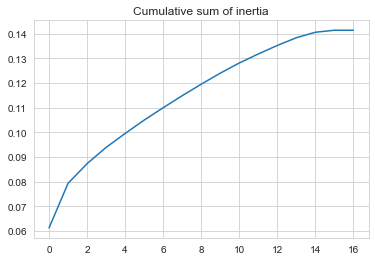

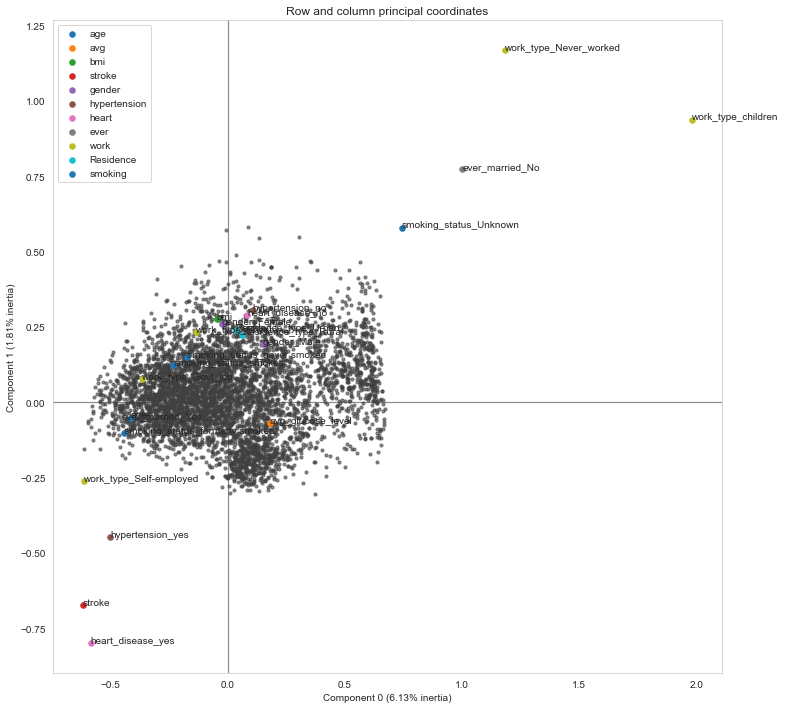

In [31]:
printMCA(df, n_components=17)

The inertia is really low since MCA only uses categorical variables.

Let's try binning the numerical variables into categorical ones in order to use them on the MCA.

In [32]:
def binNumericalVariables(X):
  r = X.copy()
  r.drop(columns=['age', 'bmi', 'avg_glucose_level'])
  r['age'] = pd.cut(X['age'], bins=[0,13,18,45,60,150], labels=['children', 'teens', 'adults', 'seniors', 'elderly'])
  r['bmi'] = pd.cut(X['bmi'], bins=[0,19,25,30,300], labels=['underweight', 'normal', 'overweight', 'obesity'])
  r['avg_glucose_level'] = pd.cut(X['avg_glucose_level'], bins=[0,90,160,230,500], labels=['low','normal','high','very high']) 
  return r

The glucose level binning is extracted from this [blog](https://agamatrix.com/blog/normal-blood-sugar-level-chart/).

In [33]:
df_mca = binNumericalVariables(df)

All variables are now encoded as binary or categorical

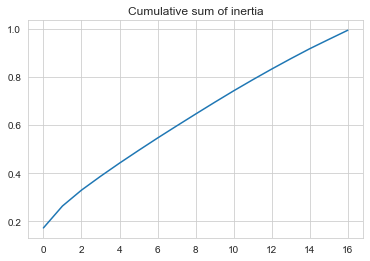

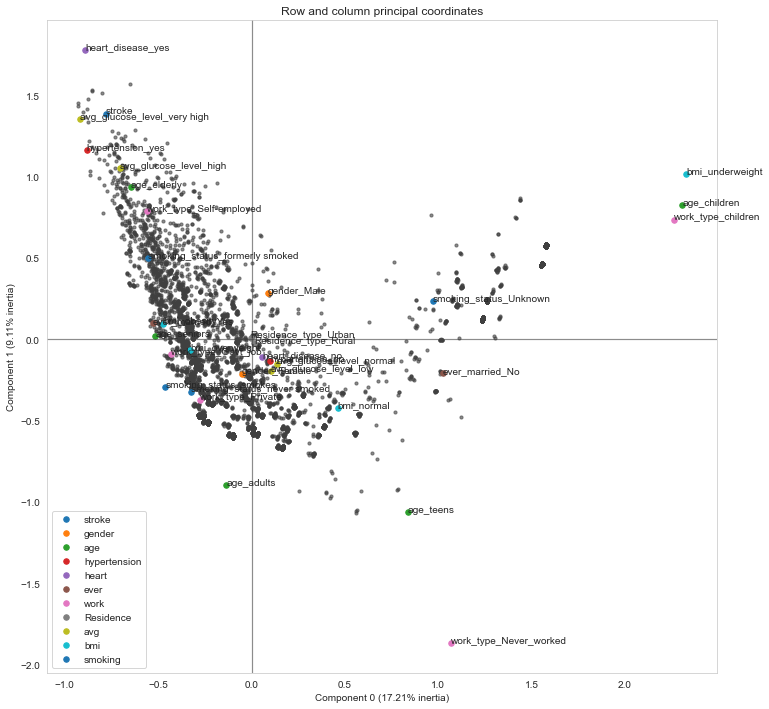

In [34]:
printMCA(df_mca, n_components=17)

We will not explore dimensionality reduction any further since the inertia in the principal axes is really low and you must pick lots of components to not lose information.

### Encoding categorical variables

Most of the classifiers do not work with categorical variables so we need to transform them into numerical ones.

In [35]:
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [36]:
df.columns.values

array(['age', 'avg_glucose_level', 'bmi', 'stroke', 'gender_Male',
       'hypertension_yes', 'heart_disease_yes', 'ever_married_Yes',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'Residence_type_Urban', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype=object)

## Modeling

Since the dataset is imbalanced, a useful baseline to beat is the _the null accuracy_. We will use the inverse since we are predicting the positive case 'stroke'.  

Our baseline will be $\approx 5\%$ for recall of positive stroke.

### Over-sampling

In order to fix the problem of imbalance, we are going to use *SMOTE* (Synthetic Minority Over-sampling Technique) which is an over-sampling method based on linear interpolation of the k-Nearest Neighbors.

Actually, we are using *SMOTETomek* which applies SMOTE and then cleans the new samples using *Tomek links*.

In [37]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler

smote = SMOTE(k_neighbors=5)
smotetomek = SMOTETomek()

# Recall, preprocessing must be applied separately. Otherwise,
# data leakage may occur.
def preprocessing(X, y, is_testing, sampling=smotetomek):
    if is_testing:
        X_re, y_re = X, y
    else:
        X_re, y_re = sampling.fit_resample(X, y)
    X_re = StandardScaler().fit_transform(X_re)
    return X_re, y_re

We start by spliting data into training, validation and testing.

In [38]:
from sklearn.model_selection import train_test_split

X = df.loc[:, df.columns != 'stroke']
y = df['stroke']

# 20 % to test since we have few samples.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

X_train, y_train = preprocessing(X_train, y_train, is_testing=False)
X_val, y_val = preprocessing(X_val, y_val, is_testing=True)
X_test, y_test = preprocessing(X_test, y_test, is_testing=True)

X_train.shape, X_val.shape, X_test.shape, 

((5802, 15), (1022, 15), (1022, 15))

Resampling has worked properly. Notice, we did not resample the validation set since it will induce false scores.

In [39]:
print(y_train.value_counts())

0    2901
1    2901
Name: stroke, dtype: int64


### Model selection

#### Scores

We have an imbalanced dataset with a baseline accuracy of 0.95.


Our final goal is to have a model that predicts all stroke i.e. a model with good **recall**. But we cannot forget about the accuracy on no-stroke class. Otherwise, we could predict everyone as stroke and have a 100% accuraccy on stroke class but this models turns out to be **useless**.

Our model has to balance both recall and precision. 
Therefore, our model will optimize **F1 score**.

In [40]:
from sklearn.metrics import make_scorer, f1_score

metrics = ['Accuracy', 
           'Recall',
           'F1-score (class 1)', 
           'F1-score (class 0)', 
           'F1-score (macro avg)',
           'ROC AUC Score',
          ]

results = pd.DataFrame(columns=metrics)

In [41]:
def plot_results():
    """Plots the results dataframe using a heatmap."""
    fig = plt.figure(figsize=(10,8))
    gs = fig.add_gridspec(2, 2)
    gs.update(wspace=0.1, hspace=0.2)
    ax0 = fig.add_subplot(gs[0, :])
    aux = results\
            .sort_values(by='F1-score (class 1)',ascending=False)\
            .apply(lambda x: x.astype(float, errors='raise'))
    sns.heatmap(
        aux, 
        cmap=cmap, 
        annot=True, 
        fmt=".1%", 
        vmin=0, vmax=0.9,
        linewidths=2.0,
        cbar=False,
        ax=ax0,
        annot_kws={"fontsize":12}
    )
    ax0.text(0,-2.15,'Result\'s Table',fontsize=12,fontweight='bold',fontfamily='serif')
    ax0.tick_params(axis=u'both', which=u'both',length=0)
    plt.show()

In [42]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def confusion_matrix(model, X, y):
    """Confusion matrix."""
    plot_confusion_matrix(
        model, 
        X, 
        y,
        display_labels=['no stroke', 'stroke'],
        cmap=plt.cm.Blues,
        normalize='true',
        colorbar=False
    )
    plt.grid(False)
    plt.title('Confusion Matrix')
    plt.show()
    
def precision_recall_curve(model, X, y):
    """Precision-Recall curve."""
    disp = plot_precision_recall_curve(model, X, y)
    disp.ax_.set_title('Precision-Recall curve')
    
def plot_roc(model, X, y):
    """Receiver Operating Characteristic curve"""
    n_classes = 2
    plt.figure()
    y_pred = model.predict_proba(X)
    colors = cycle(['tomato', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        fpr, tpr, _ = roc_curve(y, y_pred[:, i])
        plt.plot(fpr, tpr, color=color, 
                 label=f'ROC curve of class {i}')  
    
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

def compute_metrics(y_true,y_pred):
    """Returns an array with all the metrics."""
    accuracy = accuracy_score(y_true,y_pred)
    recall = recall_score(y_true,y_pred)
    f1_score_1 = f1_score(y_true,y_pred,average='binary',pos_label=1)
    f1_score_0 = f1_score(y_true,y_pred,average='binary',pos_label=0)
    f1_score_macro = f1_score(y_true,y_pred,average='macro')
    roc_score = roc_auc_score(y_true,y_pred)
    return [accuracy,
            recall,
            f1_score_1,
            f1_score_0,
            f1_score_macro,
            roc_score
           ]

def evaluate(name, model, print_results=True):
    """Evaluates the model with the validation dataset 
    and prints some statistics/metrics"""
    try:
        model = model.best_estimator_
    except Exception as e:
        pass
    y_pred = model.predict(X_val)
    results.loc[name,:] = compute_metrics(y_val, y_pred)
    if print_results:
        confusion_matrix(model, X_val, y_val)
        try:
            precision_recall_curve(model, X_val, y_val)
            plot_roc(model, X_val, y_val)
        except Exception as e:
            pass
        plot_results()

First, we are going to try several models with *default parameters*. 

Then, we are going to tune the hyperparameters of the estimators with best results. 

The models we are going to evaluate are:

- Linear Models: Logistic Regression
- Discriminant Analysis: Linear and Quadratic
- Clustering: KNN
- Support Vector Machines: SVC
- Trees: CART
- Ensemble Methods: Random Forest, AdaBoost, GradientBoostingClassifier, Voting Classifier
- Naive Bayes: Gaussian Naive Bayes
- Neural Networks: MLP

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, \
  VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
    
svc = SVC(probability=True)

dt = DecisionTreeClassifier()

ada = AdaBoostClassifier()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()

knn = KNeighborsClassifier()

lr = LogisticRegression()

qda = QuadraticDiscriminantAnalysis()

bayes = GaussianNB()

mlp = MLPClassifier(
    solver='lbfgs',
    hidden_layer_sizes=[2,2,2],
    alpha=0.1,
    activation='relu',
    max_iter=200,
)

models = { 
    'SVC(default)': svc,
    'DT(default)': dt,
    'AdaBoost(default)': ada,
    'RF(default)': rf,
    'GB(default)': gb,
    'Knn(default)': knn,
    'LR(default)': lr,    
    'QDA(default)': qda,    
    'NB(default)': bayes,    
    'MLP(default)': mlp,    
}

SVC
DT
AdaBoost
RF
GB
Knn
LR
QDA
NB
MLP


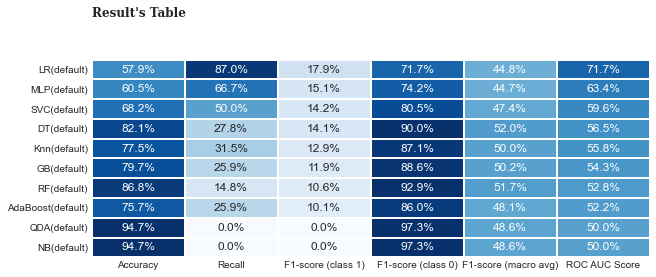

In [45]:
for name, model in models.items():
    print(name.split('(')[0])
    model.fit(X_train, y_train)
    evaluate(name, model, print_results=False)
    
plot_results()

The best classifiers so far are:
- Multi-layer perceptron
- Logistic Regression (L1 and L2)
- Decision Tree

#### Optimizing

In order to optimize the hyperparameters of each model we are going to use an exhaustive search. This is possible because the number of samples is small and the computational cost of the algorithms is polynomial.

In [46]:
from time import time, sleep
from datetime import timedelta
import json

def print_time(start, end):
    duration = timedelta(seconds=end-start)
    days, seconds = duration.days, duration.seconds
    minutes = (seconds % 3600) // 60
    seconds = (seconds % 60)
    print(f'{minutes} minutes, {seconds} seconds')
    
def print_best_params(cvModel):
    stringified = json.dumps(cvModel.best_params_, sort_keys=False, indent=2)
    print(stringified)

In [47]:
from sklearn.model_selection import GridSearchCV

def hypertune(estimator, param_grid, scoring_cols, cv=5):
    """Returns the model hypertunned."""
    
    f1_class_0_scorer = make_scorer(f1_score, pos_label=0)
    f1_class_1_scorer = make_scorer(f1_score, pos_label=1)

    scoring_dict = {
        'f1_mac': 'f1_macro',
        'f1_class_0': f1_class_0_scorer,
        'f1_class_1': f1_class_1_scorer,
        'acc': 'accuracy'
    }

    start = time()
    
    cvModel = GridSearchCV(
        estimator=estimator,
        scoring=scoring_dict,
        param_grid=param_grid,
        refit='f1_mac',
        cv=cv,
        n_jobs=-1,
        return_train_score=False
    )

    cvModel = cvModel.fit(X_train, y_train)
    
    end = time()
    print_time(start, end)
    
    scores = pd.DataFrame(cvModel.cv_results_) \
              .sort_values(by='mean_test_f1_class_1',ascending=False)[scoring_cols].head()
    
    print_best_params(cvModel)
    display(scores)
    
    
    return cvModel

#### Decision Tree

0 minutes, 6 seconds
{
  "criterion": "entropy",
  "max_depth": 20,
  "max_features": null,
  "min_samples_leaf": 1,
  "min_samples_split": 2
}


param_criterion param_max_depth param_max_features param_min_samples_leaf  \
976         entropy              20               None                      1   
476            gini              20               None                      1   
76             gini            None               None                      1   
577         entropy            None               None                      1   
576         entropy            None               None                      1   

    param_min_samples_split  mean_test_f1_mac  mean_test_f1_class_0  \
976                       2          0.926820              0.925846   
476                       2          0.926138              0.925085   
76                        2          0.925976              0.924932   
577                       3          0.925623              0.925028   
576                       2          0.925284              0.924463   

     mean_test_f1_class_1  mean_test_acc  
976              0.927794       0.926929  
476              0.927191       0.926238  
76               0.927019       0.926064  
577              0.926218       0.925722  
576              0.926105       0.925378

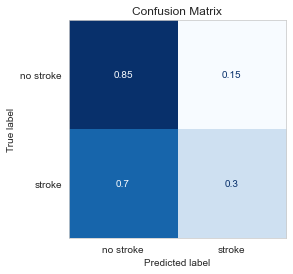

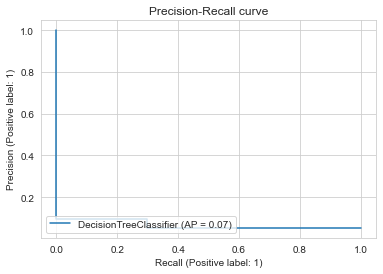

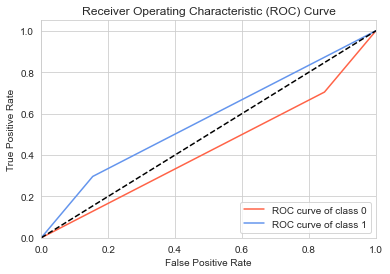

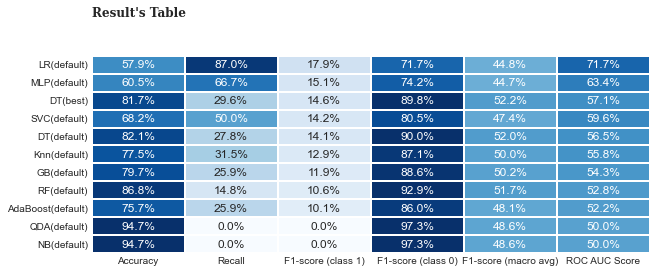

In [48]:
criterion = ['gini', 'entropy']
max_dephts = [None, 5, 10, 15, 20]
min_samples_split = [1, 2, 3, 4, 5]
min_samples_leaf = [1, 2, 3, 4, 5]
max_features = ['auto', 'sqrt', 'log2', None]
param_grid={
   'criterion': criterion,
   'max_depth': max_dephts,
   'min_samples_split': min_samples_split,
   'min_samples_leaf': min_samples_leaf,
   'max_features': max_features
}

scoring_cols = [
    'param_criterion', 'param_max_depth', 'param_max_features',
    'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_f1_mac',
    'mean_test_f1_class_0', 'mean_test_f1_class_1', 'mean_test_acc'
]

dt = DecisionTreeClassifier()
dtBest = hypertune(dt, param_grid, scoring_cols)
evaluate('DT(best)', dtBest)

Let's plot the tree to see if we can get more information about how the decision tree is discriminating the classes.

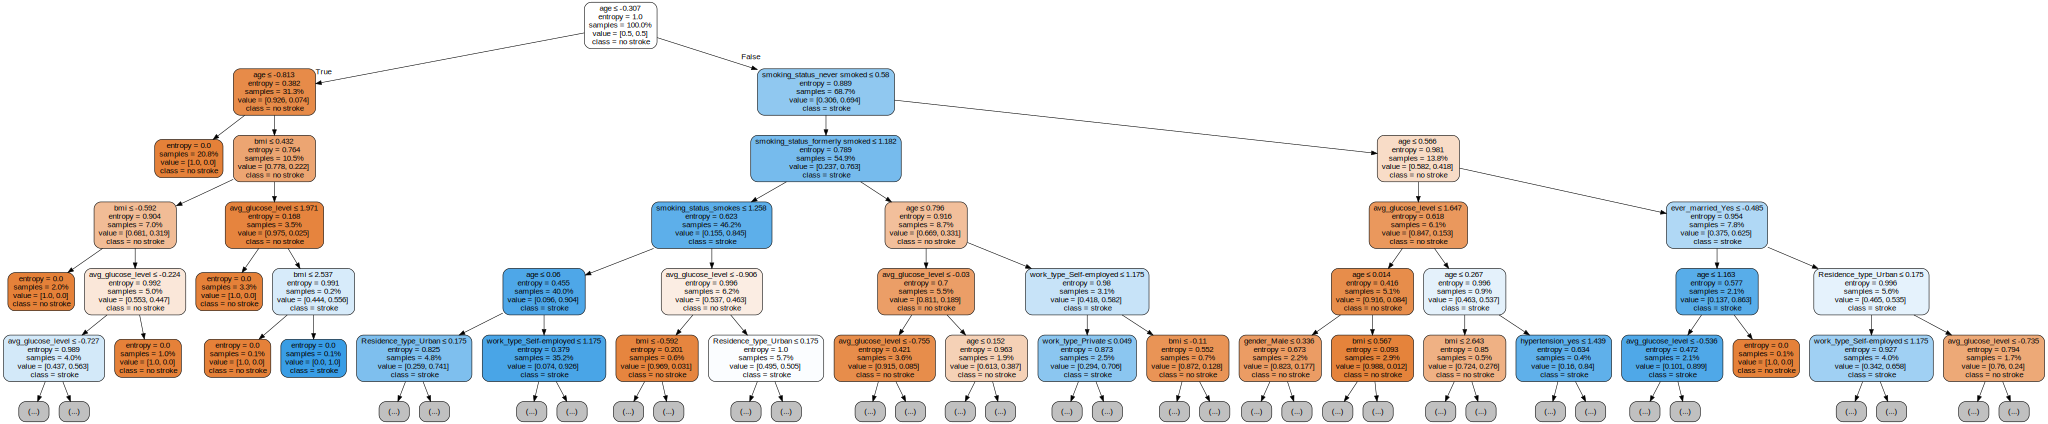

In [49]:
from sklearn.tree import plot_tree, export_graphviz
import graphviz

tree = dtBest.best_estimator_

dot_data = export_graphviz(
    tree,
    max_depth=5,
    out_file=None, 
    feature_names=X.columns,  
    class_names=['no stroke', 'stroke'],  
    filled=True,
    rounded=True,  
    special_characters=True, 
    proportion=True
)  
graph = graphviz.Source(dot_data)  
graph 

#### Analysis on Decision Tree feature importance

In [50]:
def feature_importance(model, X):
    return pd.DataFrame({'Feature':X.columns
                         , 'Importance':model.feature_importances_}
                       ).sort_values('Importance', ascending=False)

In [51]:
frame = feature_importance(dtBest.best_estimator_, X)
frame[:10].style.background_gradient(cmap=cmap)

The most relevant features are:
- Age
- Average Glucose Level
- BMI

#### Random Forest

0 minutes, 16 seconds
{
  "class_weight": "balanced_subsample",
  "max_depth": 100,
  "min_samples_leaf": 4,
  "min_samples_split": 6,
  "n_estimators": 100
}


param_max_depth param_min_samples_leaf param_min_samples_split  \
34             100                      4                       6   
9             None                      4                       4   
43            None                      4                       6   
26            None                      4                       6   
0              100                      4                       4   

    mean_test_f1_mac  mean_test_f1_class_0  mean_test_f1_class_1  \
34          0.938198              0.938242              0.938153   
9           0.938012              0.938048              0.937977   
43          0.938014              0.938109              0.937920   
26          0.938017              0.938218              0.937816   
0           0.937514              0.937356              0.937672   

    mean_test_acc  
34       0.938304  
9        0.938131  
43       0.938131  
26       0.938132  
0        0.937614

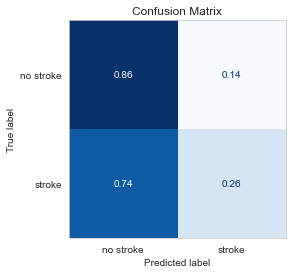

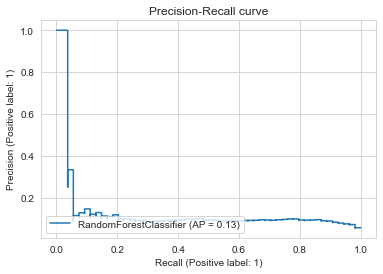

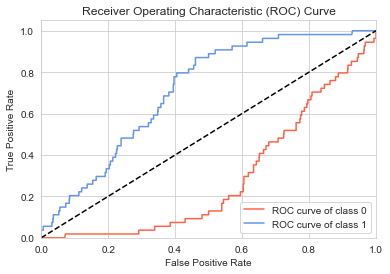

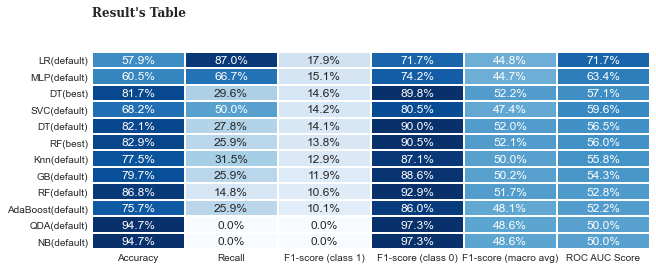

In [52]:
n_estimators = [100,200]
criterion = ['gini', 'entropy']
max_features = [2,3,5]
bootstrap = [False, True]
max_depth = [100,None]
min_samples_split = [4,6]
min_samples_leaf = [4,6]
balance = [None, 'balanced', 'balanced_subsample']
param_grid={
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf, 
    'class_weight':balance
}

scoring_cols = [
    'param_max_depth', 
    'param_min_samples_leaf', 
    'param_min_samples_split',
    'mean_test_f1_mac', 
    'mean_test_f1_class_0', 
    'mean_test_f1_class_1',
    'mean_test_acc'
]

rf = RandomForestClassifier()
rfBest = hypertune(rf, param_grid, scoring_cols)
evaluate('RF(best)', rfBest)

#### Analysis on Random Forest feature importance

In [53]:
frame = feature_importance(rfBest.best_estimator_, X)
frame[:10].style.background_gradient(cmap=cmap)

The most relevant features are:
- Age
- Average Glucose Level
- BMI

#### Logistic regression with L1/L2 regularization

0 minutes, 0 seconds
{
  "C": 10,
  "class_weight": null,
  "max_iter": 100,
  "penalty": "l2"
}


param_penalty param_C param_class_weight param_max_iter  mean_test_f1_mac  \
59            l2     100           balanced            300          0.869806   
57            l2     100           balanced            200          0.869806   
55            l2     100           balanced            100          0.869806   
53            l2     100               None            300          0.869806   
51            l2     100               None            200          0.869806   

    mean_test_f1_class_0  mean_test_f1_class_1  mean_test_acc  
59              0.870831              0.868781       0.870051  
57              0.870831              0.868781       0.870051  
55              0.870831              0.868781       0.870051  
53              0.870831              0.868781       0.870051  
51              0.870831              0.868781       0.870051

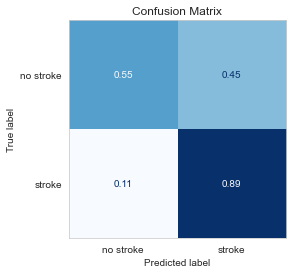

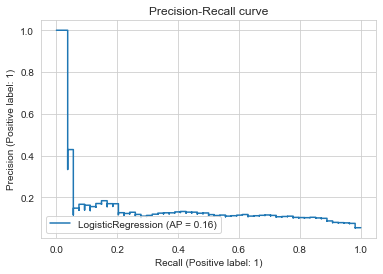

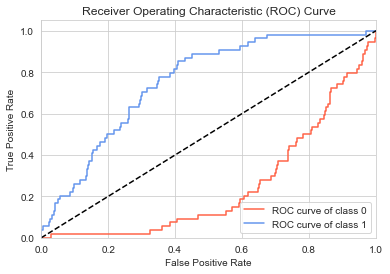

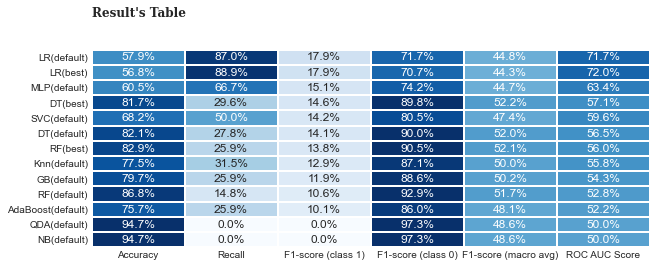

In [54]:
penalty = ['l1', 'l2']
C = [0.001, 0.01, 1, 10, 100]
balance = [None, 'balanced']
max_iter=[100,200,300]
param_grid={
    'penalty':penalty,
    'C':C,
    'class_weight':balance,
    'max_iter':max_iter
}

scoring_cols = [
    'param_penalty', 
    'param_C', 
    'param_class_weight', 
    'param_max_iter', 
    'mean_test_f1_mac', 
    'mean_test_f1_class_0', 
    'mean_test_f1_class_1',
    'mean_test_acc'
]

lr = LogisticRegression()
lrBest = hypertune(lr, param_grid, scoring_cols)
evaluate('LR(best)', lrBest)

#### MLP

In [55]:
sizes = [2*i for i in range(1,5)]
sizes = sizes + [[2*i,2*i] for i in range(1,5)]
sizes = sizes + [[2*i,2*i, 2*i] for i in range(1,5)]
alpha = [0.00001,0.0001,0.001,0.01,0.1,0.5,1]
sizes

[2,
 4,
 6,
 8,
 [2, 2],
 [4, 4],
 [6, 6],
 [8, 8],
 [2, 2, 2],
 [4, 4, 4],
 [6, 6, 6],
 [8, 8, 8]]

0 minutes, 25 seconds
{
  "alpha": 0.1,
  "hidden_layer_sizes": [
    8,
    8,
    8
  ]
}


param_hidden_layer_sizes param_alpha  mean_test_f1_mac  \
59                [8, 8, 8]         0.1          0.914923   
23                [8, 8, 8]      0.0001          0.910239   
55                   [8, 8]         0.1          0.910232   
35                [8, 8, 8]       0.001          0.910754   
71                [8, 8, 8]         0.5          0.909702   

    mean_test_f1_class_0  mean_test_f1_class_1  mean_test_acc  
59              0.913875              0.915970       0.915036  
23              0.908198              0.912280       0.910381  
55              0.909107              0.911356       0.910381  
35              0.910663              0.910846       0.910901  
71              0.908688              0.910717       0.909863

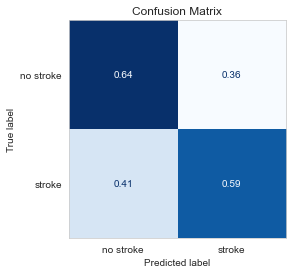

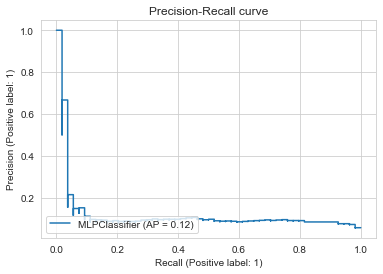

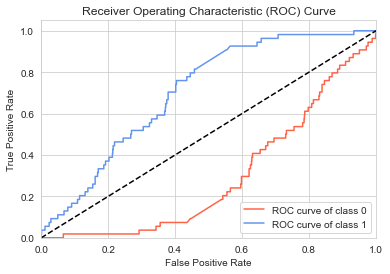

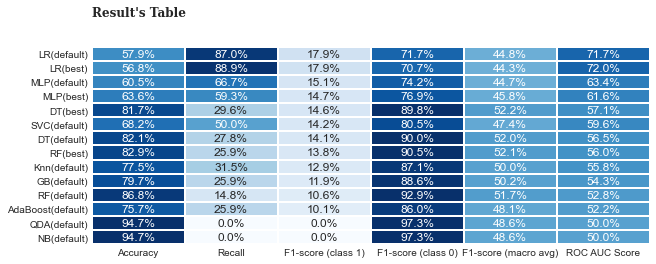

In [56]:
param_grid={
    'hidden_layer_sizes':sizes,
    'alpha':alpha # L2 penalty
}

scoring_cols = [
    'param_hidden_layer_sizes', 
    'param_alpha', 
    'mean_test_f1_mac', 
    'mean_test_f1_class_0', 
    'mean_test_f1_class_1',
    'mean_test_acc'
]

mlp = MLPClassifier(
    # better for small datasets
    solver='lbfgs', 
    activation='relu',
    max_iter=200
)
mlpBest = hypertune(mlp, param_grid, scoring_cols)
evaluate('MLP(best)', mlpBest)

#### Voting Classifier

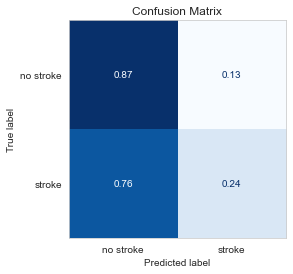

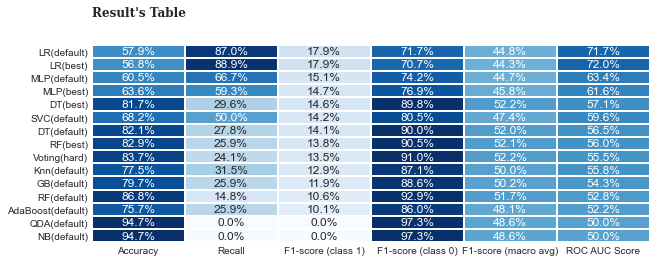

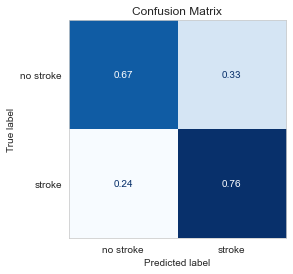

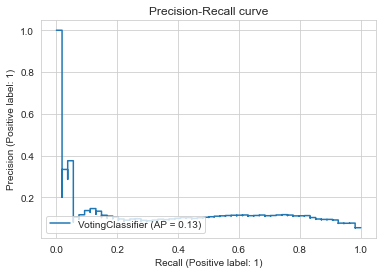

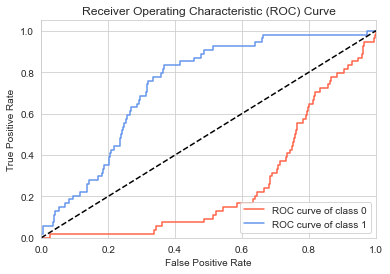

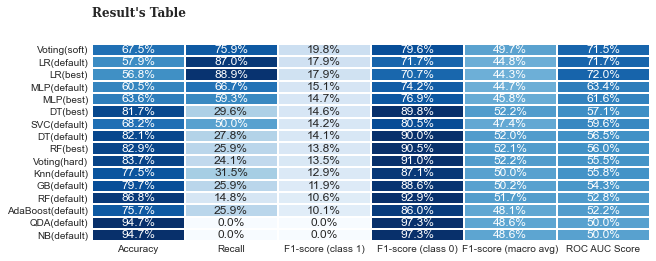

In [57]:
estimators = [
    ('rf', rfBest.best_estimator_),
    ('lr', lrBest.best_estimator_)
]

for voting in ['hard', 'soft']:
    model = VotingClassifier(estimators=estimators, voting=voting)
    model.fit(X_train, y_train)
    evaluate(f'Voting({voting})', model)

### Evaluating the results

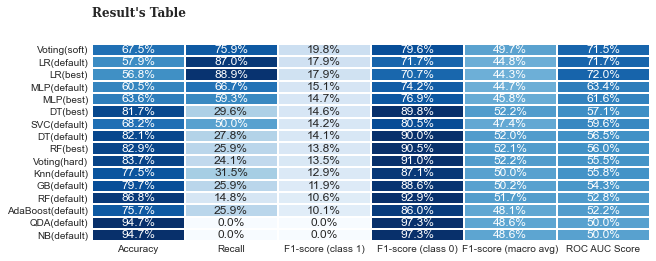

In [58]:
plot_results()

The best model is *Voting(soft)* in terms of F1-score but it
has lower recall than other models. In contrast, *Logistic Regression* scores worse on F1-score but it has a great recall (85%!).

Finally, the model we choose is **Logistic Regression with L2 penalty and C=0.01**

## Evaluating the model

              precision    recall  f1-score   support

           0       0.99      0.56      0.72       975
           1       0.09      0.87      0.16        47

    accuracy                           0.58      1022
   macro avg       0.54      0.72      0.44      1022
weighted avg       0.95      0.58      0.69      1022



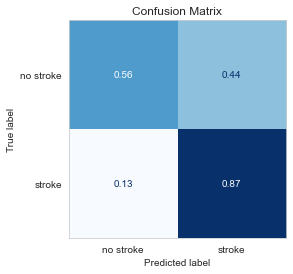

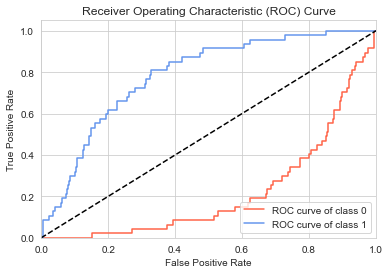

In [59]:
from sklearn.metrics import classification_report

bestModel = lrBest
y_pred = bestModel.predict(X_test)
print(classification_report(y_test,y_pred))
confusion_matrix(bestModel, X_test, y_test)
plot_roc(bestModel, X_test, y_test)

The model achieves **85% recall** on positive class which does it jobs at helping predict stroke. 

Despite the good result this score is not enough since **15%** of the patients who will suffer a stroke are missclassified.

## Future Work

In order to improve our model we will probably need more samples or more variables.

*SMOTE* helped with the imbalanced dataset but only with a 5% of samples of the positive class is not enough to get a good model.